In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import spacv
from spacv.grid_builder import *
from spacv.utils import *
import unittest

from sklearn.cluster import KMeans, MiniBatchKMeans

# Sklearn integration

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

In [3]:
df = gpd.read_file('data/baltim.geojson')

XYs = df['geometry']
X = df[['NROOM', 'BMENT', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PATIO']

skcv = spacv.SKCV(n_splits=4, buffer_radius=10).split(XYs)

svc = SVC()

cross_val_score(svc, 
                X, 
                y, 
                cv = skcv)

array([0.72727273, 0.84848485, 0.93478261, 0.88636364])

In [14]:
skcv = spacv.SKCV(buffer_radius=5).split(XYs)

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

clf = GridSearchCV(estimator=svc, 
                   param_grid=parameters, 
                   cv = skcv # An iterable yielding (train, test) splits as arrays of indices
                  )

clf.fit(X, y)

GridSearchCV(cv=<generator object BaseSpatialCV.split at 0x7fb3b3704408>,
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

# Performance

In [22]:
n = 1000000

x = np.random.randint(0, 3000, n)
y = np.random.randint(0, 3000, n)

gdf = gpd.GeoDataFrame({'geometry': gpd.points_from_xy(x,y)})
data = np.random.random((n,5))

y, gdf[['V2','V3','V4','V5']] = data[:,0], data[:,1:5]
X = gdf[['V2', 'V3', 'V4', 'V5']].values

XYs = gdf['geometry']

### H-blocking

In [32]:
cv = spacv.HBLOCK(10,5, method='unique', buffer_radius=500)

%%timeit
for tr,te in cv.split(XYs):
    pass

### Spatial K-fold

In [65]:
cv = spacv.SKCV(folds=10)

%%timeit
for tr,te in cv.split(XYs):
    pass

In [66]:
cv = spacv.SKCV(folds=10, buffer_radius=500)

%%timeit
for tr,te in cv.split(XYs):
    pass

### Repeat Spatial K-fold

In [68]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2)

%%timeit
for tr,te in cv.split(XYs):
    pass

In [70]:
cv = spacv.RepeatSKCV(folds=10, n_repeats=2, buffer_radius=500)

%%timeit
for tr,te in cv.split(XYs):
    pass

### SLOO

In [9]:
sample_XYs = XYs.sample(100000)

In [10]:
cv = spacv.SKCV(folds= len(sample_XYs))

In [12]:
%%timeit -r 1 -n 1
for tr,te in cv.split(sample_XYs):
    pass

8min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### User defined polygons

In [191]:
custom_example_poly = gpd.read_file('data/holes_example.geojson')
custom_example_pts = gpd.read_file('data/holes_example_pts.geojson')

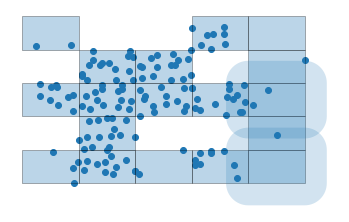

In [81]:
f, ax = plt.subplots(1,figsize=(6,4))
custom_example_pts.plot(ax=ax)
custom_example_poly.plot(ax=ax,alpha=.3, edgecolor='black')
custom_example_poly.sample(2, random_state=123).buffer(10).plot(ax=ax, alpha=.2), ax.axis('off');

In [66]:
cv = spacv.UserDefinedSCV(custom_polygons = custom_example_poly, buffer_radius=10)

In [67]:
%%timeit
for tr,te in cv.split(custom_example_pts):
    pass

538 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Ad-hoc grid/fold construction

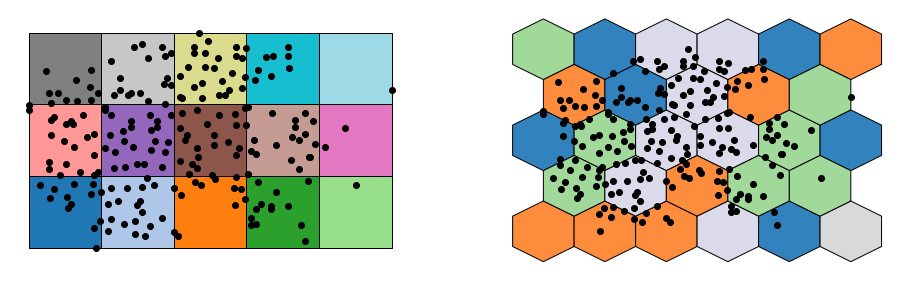

In [64]:
f, ax = plt.subplots(1,2, figsize=(16,16))
construct_blocks(XYs, tiles_x=5, tiles_y=3, method='unique').plot(column='grid_id',
                                edgecolor='black', cmap='tab20',ax=ax[0])

hexgrid = construct_blocks(XYs, tiles_x=5, tiles_y=2, 
                 method='optimized_random', n_sims=10, data=X,
                 n_groups=5, shape='hex')

hexgrid.plot(column='grid_id', cmap='tab20c',ax=ax[1], edgecolor='black')
XYs.plot(ax=ax[0], color='black'),XYs.plot(ax=ax[1], color='black')
ax[0].axis('off'), ax[1].axis('off')
plt.show()

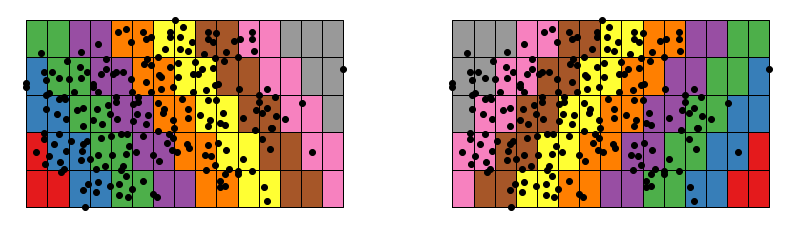

In [25]:
f, ax = plt.subplots(1,2, figsize=(14,12))

construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='anti').plot(column='grid_id', cmap='Set1', 
                                                                                         ax=ax[0], edgecolor='black')
construct_blocks(XYs, method='systematic', tiles_x=15, tiles_y=5, direction='diagonal').plot(column='grid_id', cmap='Set1', 
                                                                                             ax=ax[1], edgecolor='black')
XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black')
ax[0].axis('off'), ax[1].axis('off');

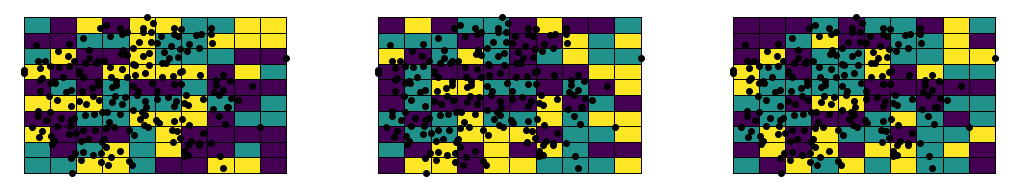

In [30]:
f, ax = plt.subplots(1,3, figsize=(18,20))
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[0], edgecolor='black', cmap='viridis')
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[1], edgecolor='black', cmap='viridis')
construct_blocks(df, method='random', tiles_x=10, tiles_y=10, n_groups=3).plot(column='grid_id', ax=ax[2], edgecolor='black', cmap='viridis')
XYs.plot(ax=ax[0], color='black')
XYs.plot(ax=ax[1], color='black')
XYs.plot(ax=ax[2], color='black')
ax[0].axis('off'), ax[1].axis('off'), ax[2].axis('off');

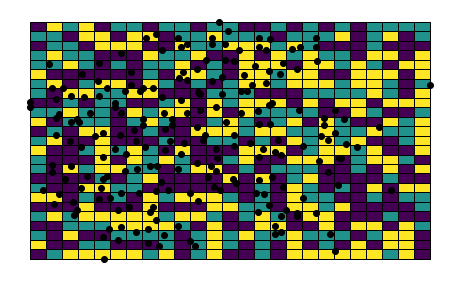

In [32]:
f, ax = plt.subplots(1, figsize=(8,8))
construct_blocks(df, method='optimized_random', data=X, tiles_x=25, tiles_y=25, 
                 n_groups=3, n_sims=10, distance_metric='euclidean').plot(column='grid_id', ax=ax, cmap='viridis', edgecolor='black')
df.plot(ax=ax, color='black')
ax.axis('off');

# Visualisaton

In [42]:
df = gpd.read_file('/opt/conda/lib/python3.7/site-packages/libpysal/examples/baltim/baltim.shp')

XYs = df['geometry']
cols = ['NROOM', 'PRICE', 'AGE', 'SQFT']
X = df[cols]
y = df['PATIO']

/opt/conda/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.64623517 0.92555732]
[450.22797385 255.34685049]
[412.20627954 255.72316691]
[67.31997408 46.95668568]


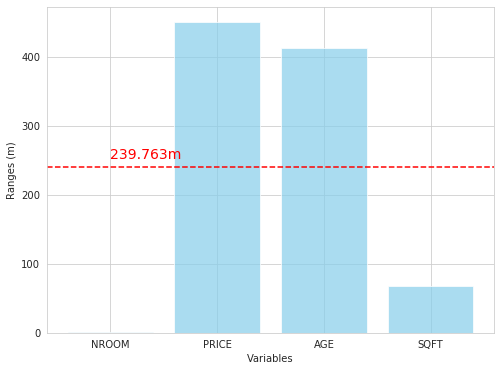

In [58]:
lags = np.arange(0, y_suggested, 20)
bw = 10

f, ax = plot_autocorrelation_ranges(XYs, X[cols], lags, bw)

In [75]:
df['demo_labs'] = KMeans(6).fit(geometry_to_2d(df.geometry)).labels_
new_data = df[df['demo_labs'] == 1].copy()
training_data = df[df['demo_labs'] != 1]
columns = ['NROOM', 'DWELL', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']

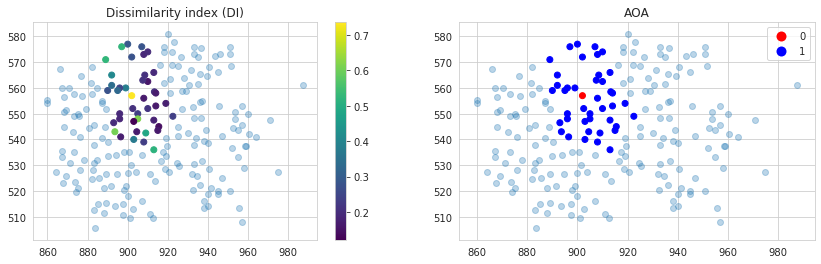

In [22]:
f, ax = plot_aoa(new_data, training_data, columns, (14,4))

# Future

* Spatially-explicit GCV
* Bootstrap samples from within folds testing